In [1]:
# Installing/importing all the required libraries

! pip install openpyxl
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Reading the dataset and separating all the individual sheets from the excel dataset.

supply_df = pd.read_excel("Supply chain logisitcs problem.xlsx", sheet_name=None)

ol_df, fr_df, whco_df, whcap_df, prppl_df, vc_df, plpo_df = supply_df.values()

ol_df.columns = [i.replace(" ", "_") for i in ol_df.columns]
whco_df.columns = [i.replace(" ", "_") for i in whco_df.columns]
whcap_df.columns = [i.replace(" ", "_") for i in whcap_df.columns]
prppl_df.columns = [i.replace(" ", "_") for i in prppl_df.columns]
vc_df.columns = [i.replace(" ", "_") for i in vc_df.columns]
plpo_df.columns = [i.replace(" ", "_") for i in plpo_df.columns]

In [13]:
# Checking one-by-one to verify whether the dataset has any null values

ol_df.isna().sum()

#fr_df.isna().sum()

#whco_df.isna().sum()

#prppl_df.isna().sum()

#vc_df.isna().sum()

#plpo_df.isna().sum()

Order_ID            0
Customer            0
Product_ID          0
Destination_Port    0
Unit_quantity       0
Weight              0
dtype: int64

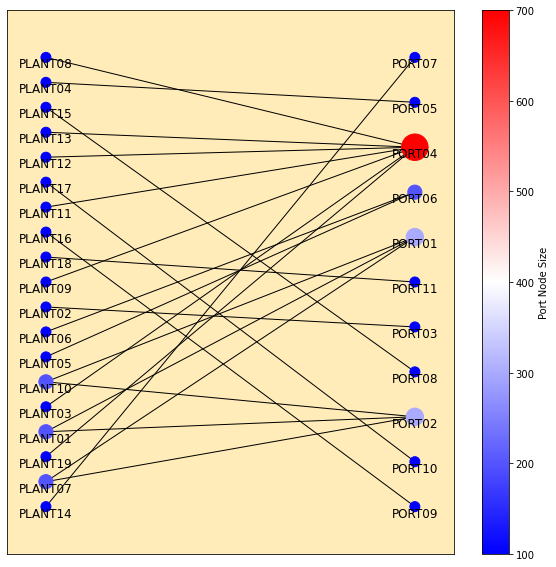

In [14]:
plpo_viz = nx.from_pandas_edgelist(plpo_df, source="Plant_Code", target="Port")

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor("#FFECB8")

# specify layout for the graph
layout = nx.bipartite_layout(plpo_viz, plpo_df["Plant_Code"])

for i in layout:
    if i.startswith("PLANT"):
        layout[i][0] -= 0.1
    else:
        layout[i][0] += 0.1

# we want to map the degree of the node to a color/size
degrees = dict(plpo_viz.degree)
node_sizes = [v * 100 for v in degrees.values()]

# specify the color map
cmap = plt.cm.bwr

# draw nodes with labels below
nodes = nx.draw_networkx_nodes(plpo_viz, pos=layout, node_size=node_sizes, node_color=node_sizes, cmap=cmap, ax=ax)
nodes.set_zorder(2)  # ensure nodes are on top

# draw edges
nx.draw_networkx_edges(plpo_viz, pos=layout, ax=ax)

# draw labels
nx.draw_networkx_labels(plpo_viz, pos=layout, ax=ax, verticalalignment="top")

# create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(node_sizes)
cbar = plt.colorbar(sm, ax=ax, label="Port Node Size")

plt.show()

In [15]:
# Creating IDs as indexes for the tables

ol_df.set_index("Order_ID", inplace=True)
whco_df.set_index("Plant_Code", inplace=True)
whcap_df.set_index("Plant_ID", inplace=True)

In [16]:
# For optimizing the production flow and minimizing the transportation cost in the supply chain process, we will have to define a new function to check the number of plants that can process the order. 
# For this purpose we will have to check two thing: The plants that can process the orders; and the plants that can service particular customers

def order_plant(index):
    order_data = ol_df.loc[index]
    product_id = order_data["Product_ID"]
    plant_list = prppl_df.loc[prppl_df["Product_ID"] == product_id]
    return np.array(plant_list["Plant_Code"])

def cust_plant(index):
    order_data = ol_df.loc[index]
    Customer_id = order_data["Customer"]
    plant_list = vc_df.loc[vc_df["Customers"] == Customer_id]
    if list(plant_list["Plant_Code"]) == []:
        return plpo_df["Plant_Code"].unique()
    else:
        return np.array(plant_list["Plant_Code"])
    
def order_fulfillment(Order_Id, length=True):
    if length:
        return len(np.intersect1d(cust_plant(Order_Id), order_plant(Order_Id)))
    else:
        return np.intersect1d(cust_plant(Order_Id), order_plant(Order_Id))

In [17]:
# Using the defined function, we will create a new column in our ol_df to calculate how many plants can process a new order from a given client

ol_df["No_of_plants"] = np.array(list(map(order_fulfillment, ol_df.index)))

In [18]:
ol_df["No_of_plants"].value_counts()

1    6275
0    1045
4     982
2     785
3     127
5       1
Name: No_of_plants, dtype: int64

In [19]:
#Assigning orders and avergaing the weights for each port and use those as the costs.
fr_df["rate"].describe()

count    1540.000000
mean        2.892656
std         4.603877
min         0.033200
25%         0.470400
50%         1.661200
75%         3.932200
max       128.027200
Name: rate, dtype: float64

In [20]:
ports_avg = fr_df.groupby(["orig_port_cd"]).agg(avg_rate=("rate", np.mean))

In [21]:
#Excluding the orders that cannot be processed by any facilities.
ol_df = ol_df.loc[ol_df.No_of_plants != 0]

In [22]:
#Displaying the plants that can process the order
ol_df["No_of_plants"] = np.array((map(lambda x: order_fulfillment(x, length=False), ol_df.index)))

C:\Users\deepa\AppData\Local\Temp\ipykernel_49792\3647991269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ol_df["No_of_plants"] = np.array((map(lambda x: order_fulfillment(x, length=False), ol_df.index)))


In [23]:
def min_cost(dec_space):
    
    plant_port_cost = {}
    
    wh = whco_df.copy()
    min_cost = np.inf
    
    for plant in dec_space:
        plant_port_cost[plant] = wh.loc[plant].iloc[0]
        port_price, port = find_best_port(plant)
        plant_port_cost[plant] += port_price
        
        if plant_port_cost[plant] < min_cost:
            min_cost = plant_port_cost[plant]
            best_plant = plant
            best_port = port
            best_port_price = port_price
        
    return min_cost, best_plant, best_port_price, best_port

In [24]:
def find_best_port(plant_id):
    # choosing the ports that have a connection to the given plant and then finding the port with the lowest freight rate
    possible_ports = plpo_df.loc[(plpo_df.Plant_Code == plant_id) & (plpo_df.Port != "PORT01"), "Port"]
    possible_ports = ports_avg.loc[possible_ports]
    return possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0]["avg_rate"], possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0].name
    

In [25]:
ol_df["decision"] = ol_df["No_of_plants"].apply(min_cost)

C:\Users\deepa\AppData\Local\Temp\ipykernel_49792\991733950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ol_df["decision"] = ol_df["No_of_plants"].apply(min_cost)


In [26]:
ol_df["decision"]

Order_ID
1.447296e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447158e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447139e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
                                      ...                        
1.447372e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447372e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447328e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447358e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447287e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
Name: decision, Length: 8170, dtype: object

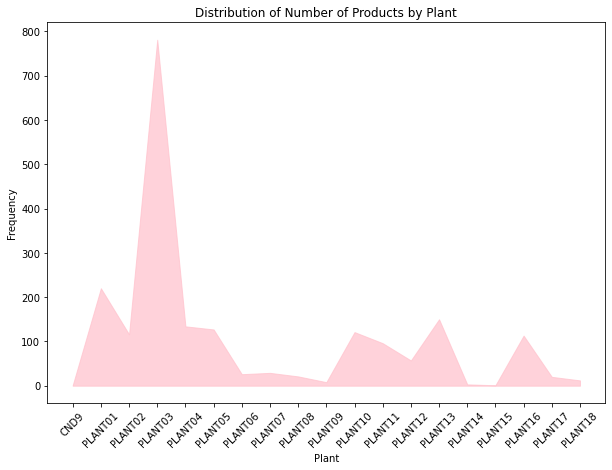

In [62]:
#Plotting a graph on how many products each plant manufactures

# Calculate the frequency of each plant
plant_counts = prppl_df["Plant_Code"].value_counts().sort_index()

# Create the area chart
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.fill_between(plant_counts.index, plant_counts.values, alpha=0.7, color="pink")

# Set the title and labels
plt.title("Distribution of Number of Products by Plant")
plt.xlabel("Plant")
plt.ylabel("Frequency")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()


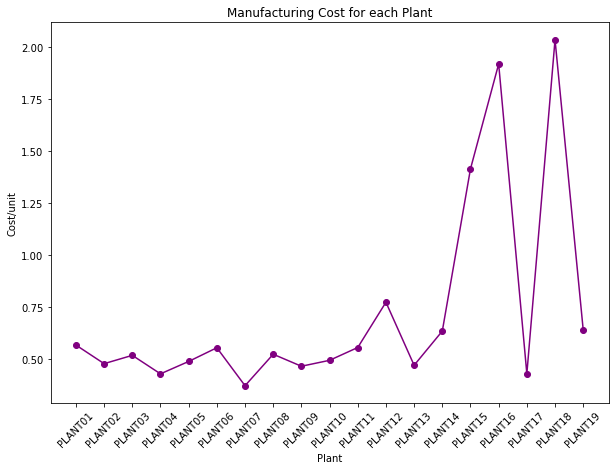

In [61]:
#Plotting a graph to show the manufacturing cost for each Plant
# Create the line graph
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(whco_df.index, whco_df["Cost/unit"], '-o', color='purple')

# Set the title and labels
plt.title("Manufacturing Cost for each Plant")
plt.xlabel("Plant")
plt.ylabel("Cost/unit")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()
